# **Symbolic Regression with PySR**

In this notebook we check the results of the Symbolic Regression with PySR. We check the results of the non-physics informed symbolic regression as well as the results of the physics informed symbolic regression.

First view the equations found by the symbolic regression together with the MSE and R^2. We than view the residuals and perform a SHAP analysis on the equation with the best R^2.

In [14]:
import pandas as pd
import numpy as np
import sys
import os
# Load and preprocess data
sys.path.append(os.path.abspath("../external/AlphaPEM"))

In [15]:
from sklearn.model_selection import train_test_split
data = pd.read_pickle(r"../data/processed/validated_final_57344.pkl")

# Filter out curves with negative voltage values
data = data[data['Ucell'].apply(lambda x: all(val > 0 for val in x))]

exploaded_df = data.explode(['ifc', 'Ucell'])

np.random.seed(42)

parameters = ['Tfc', 'i0_c_ref', 'Pa_des', 'kappa_c', 'kappa_co', 'tau', 'Re', 'ifc']

# Get unique curve IDs and split train/test
unique_ids = data['SHA256'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)


# Get the same test set that was used in the `run_PySR.py` script
test_df = exploaded_df[exploaded_df['SHA256'].isin(test_ids)]

## **Non physics-informed symbolic regression**

We load all pysr equations and filter only the equations coming from the run we are interested in.

In [26]:
import os
import pandas as pd

def load_all_pysr_equations(base_dir="../models/pysr_equations/", output_csv="all_equations_combined.csv"):
    """
    Loop through subfolders in a given directory, read each equations.csv file,
    and combine all equations into a single DataFrame.

    Args:
        base_dir (str): Path to the directory containing PySR model subfolders.
        output_csv (str): Output CSV path to save the combined equations.
    
    Returns:
        pd.DataFrame: Combined DataFrame of all equations.
    """
    all_equations = []

    for subdir in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, subdir)
        equations_file = os.path.join(folder_path, "hall_of_fame.csv")

        if os.path.isdir(folder_path) and os.path.isfile(equations_file):
            df = pd.read_csv(equations_file)
            df["model_folder"] = subdir  # track which folder it came from
            all_equations.append(df)

    if not all_equations:
        print("No equations.csv files found.")
        return pd.DataFrame()

    combined_df = pd.concat(all_equations, ignore_index=True)
    if output_csv is not None:
        combined_df.to_csv(output_csv, index=False)
        print(f"Saved combined equations to {output_csv}")
    return combined_df

df_all_equations = load_all_pysr_equations(output_csv=None)
df_all_equations = df_all_equations[df_all_equations['model_folder'] == '20250728_153342']  # Filter the PySR model folder
df_all_equations

,Complexity,Loss,Equation,model_folder
0,1,0.028231,0.71649367,20250728_153342
1,3,0.027284,249.33754 / Tfc,20250728_153342
2,4,0.010970,exp(ifc * -0.229922),20250728_153342
3,5,0.010858,inv(log(ifc + 2.7495902)),20250728_153342
4,6,0.010570,inv((ifc * 0.2868409) + 1.0120518),20250728_153342
5,7,0.009260,exp((inv(i0_c_ref) + ifc) * -0.22105232),20250728_153342
6,8,0.008759,inv(exp(ifc * 0.20674461) + inv(i0_c_ref)),20250728_153342
7,9,0.007396,(i0_c_ref + 302.89352) / (Tfc + (ifc * 97.37452)),20250728_153342
8,10,0.006836,(ifc * -0.14658587) + (log(Pa_des * i0_c_ref) ...,20250728_153342
9,12,0.005738,(ifc * -0.1474275) + (log(Pa_des * i0_c_ref) *...,20250728_153342


We convert the PySR equations into lambda equations and evaluate them in order to get the predicted voltage as well as R^2 and MSE values.

In [ ]:
import numpy as np
import pandas as pd
from sympy import sympify, symbols, lambdify
from sklearn.metrics import r2_score, mean_squared_error

# Define NumPy-safe unary operators
numpy_locals = {
    'square': lambda x: np.power(x, 2),
    'cube': lambda x: np.power(x, 3),
    'inv': lambda x: 1 / x,
    'neg': lambda x: -x,
}

def evaluate_equations_with_parameters(df_equations, X, y, parameters):
    results = []
    X_df = pd.DataFrame(X, columns=parameters)

    for _, row in df_equations.iterrows():
        equation_str = str(row['Equation'])

        try:
            # Replace x0, x1, ... with parameter names
            for i, name in enumerate(parameters):
                equation_str = equation_str.replace(f'x{i}', name)

            # Parse without custom locals — just pure sympy parsing
            expr = sympify(equation_str)

            # If scalar (no variables)
            if len(expr.free_symbols) == 0:
                y_pred = np.full_like(y, float(expr), dtype=np.float64)
            else:
                variables = sorted([str(s) for s in expr.free_symbols])
                sym_vars = symbols(variables)

                # lambdify using numpy functions + custom ops
                f = lambdify(sym_vars, expr, modules=[numpy_locals, 'numpy'])

                inputs = [X_df[var].values for var in variables]
                y_pred = f(*inputs)

            y_pred = np.array(y_pred, dtype=np.float64)

            if np.any(np.isnan(y_pred)) or np.any(np.isinf(y_pred)):
                raise ValueError("Prediction contains NaN or Inf")

            r2 = r2_score(y, y_pred)
            mse = mean_squared_error(y, y_pred)

        except Exception as e:
            print(f"❌ Failed to evaluate equation: {row['Equation']}\n   Error: {e}")
            r2 = mse = np.nan

        results.append({
            'equation': row['Equation'],
            'r2': r2,
            'mse': mse,
            'Ucell': np.array(y),
            'Ucell_pred': y_pred
        })

    return pd.DataFrame(results)


df = test_df[parameters].copy()
df['ifc'] = df['ifc'].astype(float)  # Ensure ifc is float for consistency
results = evaluate_equations_with_parameters(
    df_all_equations,
    df,
    test_df['Ucell'],
    parameters
)

results.sort_values(by='r2', ascending=False, inplace=True)

Create latex code for the PySR formulas and display them sorted by R^2.

In [23]:
from sympy import sympify, latex
import re

def add_latex_column(results_df, parameters):
    latex_eqs = []

    for eq in results_df['equation']:
        # Replace x0, x1, ... with actual parameter names
        for i, name in enumerate(parameters):
            eq = eq.replace(f"x{i}", name)

        # Replace inv(...) → 1/(...)
        eq = eq.replace("inv(", "1/(")

        # Replace square(...) → (...**2)
        eq = re.sub(r"square\(([^()]+)\)", r"(\1**2)", eq)

        try:
            expr = sympify(eq)
            latex_str = latex(expr)

            # Post-LaTeX substitutions
            latex_str = latex_str.replace("i_{0 c ref}", "i_{0,c}^{ref}")
            latex_str = latex_str.replace("Pa_{des}", "P_{a,des}")
            latex_str = latex_str.replace("ifc", "i_{fc}")
            latex_str = latex_str.replace("Tfc", "T_{fc}")
            latex_str = latex_str.replace("Re", "R_e")

            latex_eqs.append(latex_str)
        except Exception as e:
            latex_eqs.append(f"Invalid: {e}")

    results_df['latex'] = latex_eqs
    return results_df

results_df = add_latex_column(results, parameters)

In [24]:
from IPython.display import display, Math

for _, row in results_df.head(30).iterrows():
    eq_latex = row['latex']
    r2 = row['r2']
    mse = row['mse']
    
    display(Math(
        rf"\text{{Equation: }} {eq_latex} \\ \text{{R}}^2 = {r2:.4f}, \quad \text{{MSE}} = {mse:.4f}"
    ))



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [53]:
from sklearn.metrics import r2_score, mean_squared_error
# Get the index of the row with the highest R²
best_idx = results_df['r2'].idxmax()
prediction = results_df['Ucell_pred'][best_idx]

r2 = r2_score(test_df['Ucell'], prediction)
mse = mean_squared_error(test_df['Ucell'], prediction)

print(f"R² score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
residuals = test_df['Ucell'] - prediction

R² score: 0.8540
Mean Squared Error: 0.0042


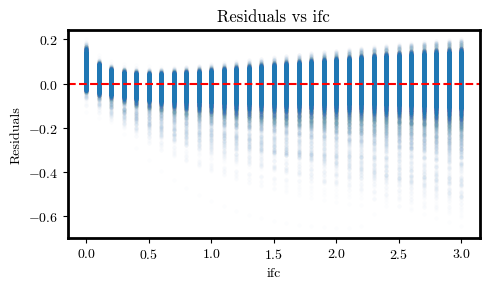

In [250]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 3))
sns.scatterplot(
    x=test_df['ifc'], 
    y=residuals, 
    alpha=0.01,        # Makes points semi-transparent
    s=10              # Smaller marker size
)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs ifc")
plt.xlabel("ifc")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()


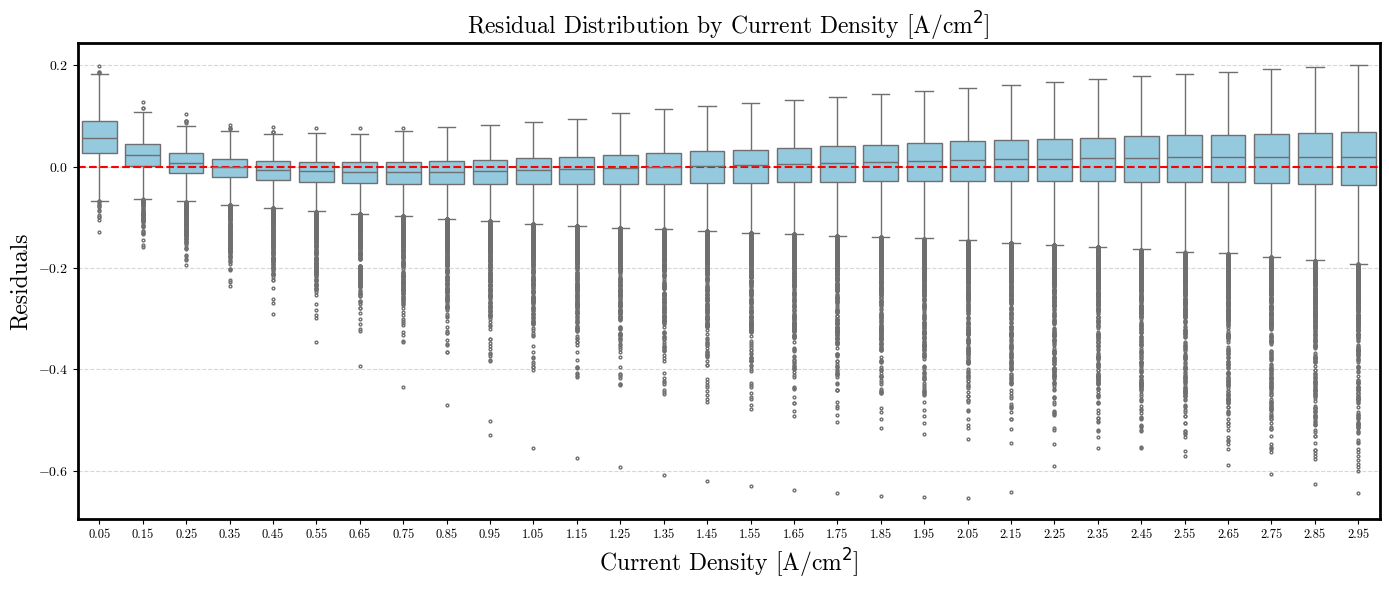

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Bin the 'ifc' values to create groups (like current_density_index)
# You can adjust the number of bins if needed
test_df = test_df.copy()
test_df['ifc_bin'] = pd.cut(test_df['ifc'], bins=30, labels=False) + 1  # 1-indexed bins
test_df['residual'] = residuals

# Calculate bin centers for x-axis labels
bin_edges = pd.cut(test_df['ifc'], bins=30).unique().categories
bin_centers = [(interval.left + interval.right) / 2 for interval in bin_edges]
bin_labels = [f"{center:.2f}" for center in bin_centers]

plt.figure(figsize=(14, 6))
sns.boxplot(
    data=test_df,
    x='ifc_bin',
    y='residual',
    color='skyblue',
    fliersize=2,
    linewidth=1
)

plt.axhline(0, color="red", linestyle="--")
plt.xticks(ticks=range(len(bin_labels)), labels=bin_labels, fontsize=9)
plt.title("Residual Distribution by Current Density [A/cm$^2$]", fontsize=17)
plt.xlabel("Current Density [A/cm$^2$]", fontsize=17)
plt.ylabel("Residuals", fontsize=17)
plt.grid(True, linestyle='--', axis='y', alpha=0.5)
plt.tight_layout()
plt.show()


In [55]:
import numpy as np
import pandas as pd

# Define bin edges
bins = np.arange(-0.8, 0.4 + 0.2, 0.2)  # [-0.8, -0.6), ..., [0.2, 0.4)

# Bin residuals (right=False makes bins like [a, b))
binned = pd.cut(residuals, bins=bins, right=False)

# Count values per bin
counts = binned.value_counts().sort_index()

# Compute percentages
percentages = counts / counts.sum() * 100

# Combine into one DataFrame
summary = pd.DataFrame({
    "Count": counts,
    "Percentage": percentages.round(2)  # optional: round for readability
})

print(summary)


                    Count  Percentage
Ucell                                
[-0.8, -0.6)           13        0.00
[-0.6, -0.4)          591        0.18
[-0.4, -0.2)         3878        1.15
[-0.2, -2.22e-16)  149440       44.49
[-2.22e-16, 0.2)   181992       54.18
[0.2, 0.4)              2        0.00


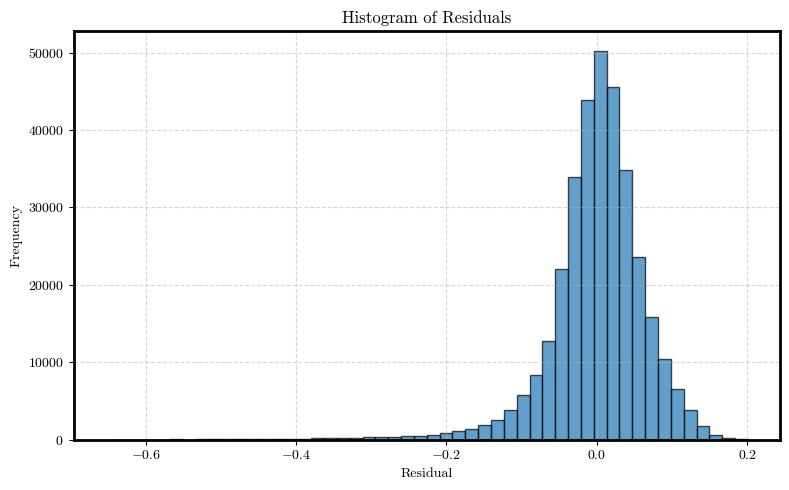

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [57]:
import numpy as np
import pandas as pd

class SymbolicModel:
    def __init__(self, equation: str):
        # Replace textual math with numpy and ^ with ** for Python
        self.equation = (
            equation.replace("log", "np.log")
                    .replace("exp", "np.exp")
                    .replace("cube", "cube")
                    .replace("^", "**")
        )
        self.feature_names = None  # will set later if needed

    def predict(self, X):
        # Define cube in local environment
        local_env = {"np": np, "cube": lambda x: x ** 3}

        # For pandas DataFrame input
        if isinstance(X, pd.DataFrame):
            self.feature_names = X.columns.tolist()
            return X.apply(lambda row: eval(self.equation, local_env, row.to_dict()), axis=1)

        # For NumPy array input
        elif isinstance(X, np.ndarray):
            if self.feature_names is None:
                raise ValueError("Feature names must be set before calling predict with numpy array.")
            X_df = pd.DataFrame(X, columns=self.feature_names)
            return self.predict(X_df)

        # For dict input
        elif isinstance(X, dict):
            return eval(self.equation, local_env, X)

        else:
            raise ValueError("Input must be a dict, DataFrame, or numpy array.")





In [ ]:
import shap
model = SymbolicModel(results_df.iloc[0]['equation'])
explainer = shap.KernelExplainer(model.predict, test_df[parameters].sample(1000, random_state=1))
shap_values = explainer.shap_values(test_df[parameters].sample(1000, random_state=1), nsamples=100)



Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 1000/1000 [1:42:36<00:00,  6.16s/it] 


C:\Users\dejvi\AppData\Local\Temp\ipykernel_1116\1711972388.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, sample_df, show=False)


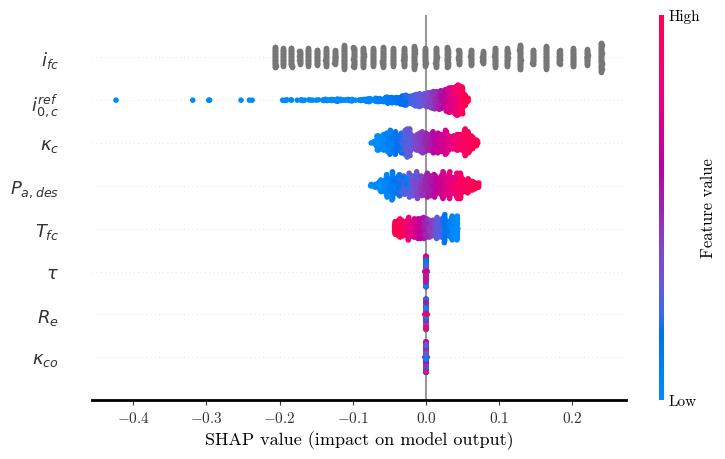

In [155]:
import matplotlib.pyplot as plt
import shap

# Your original feature name to LaTeX mapping
latex_map = {
    'ifc': r'$i_{fc}$',
    'i0_c_ref': r'$i_{0,c}^{ref}$',
    'kappa_c': r'$\kappa_c$',
    'Pa_des': r'$P_{a,des}$',
    'Tfc': r'$T_{fc}$',
    'tau': r'$\tau$',
    'Re': r'$R_e$',
    'kappa_co': r'$\kappa_{co}$'
}


# 1. Use original DataFrame with original column names (or renamed if you prefer)
sample_df = test_df[parameters].sample(1000, random_state=1)

# 2. Plot with original column names but capture the current axis and do not show yet
shap.summary_plot(shap_values, sample_df, show=False)

# 3. Get the y-tick labels currently set by SHAP (these are the feature names in order of importance)
ax = plt.gca()
current_labels = [label.get_text() for label in ax.get_yticklabels()]

# 4. Map current labels to LaTeX using your dictionary
latex_labels = [latex_map.get(label, label) for label in current_labels]

# 5. Set new y-tick labels with LaTeX
ax.set_yticklabels(latex_labels)

plt.show()


C:\Users\dejvi\AppData\Local\Temp\ipykernel_1116\1312280678.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, sample_df, plot_type="bar", show=False)


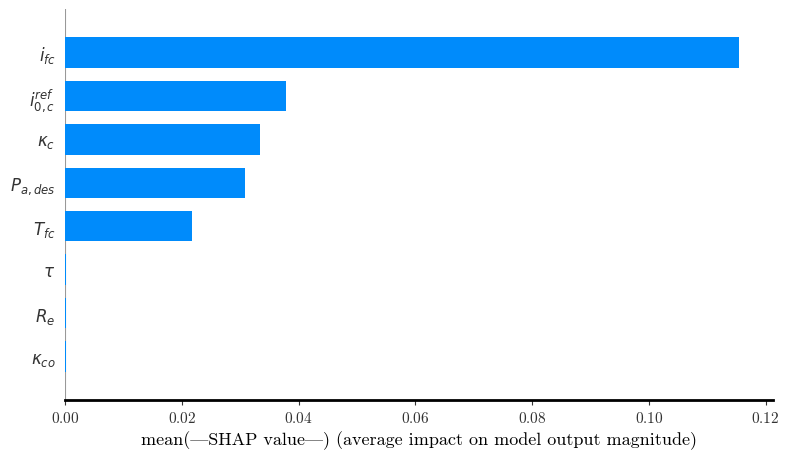

In [156]:
# Create the bar plot but do not show yet
shap.summary_plot(shap_values, sample_df, plot_type="bar", show=False)

ax = plt.gca()
current_labels = [label.get_text() for label in ax.get_yticklabels()]

# Map to LaTeX, default to original if not found
latex_labels = [latex_map.get(label, label) for label in current_labels]

# Set new y-axis tick labels with LaTeX formatting
ax.set_yticklabels(latex_labels, fontsize=12)

plt.tight_layout()
plt.show()


## **Physics-informed symbolic regression**

In [59]:
df_all_equations_informed = load_all_pysr_equations(output_csv=None)
df_all_equations_informed = df_all_equations_informed[df_all_equations_informed['model_folder'] == '20250729_173022_r6IoKZ']
df_all_equations_informed

,Complexity,Loss,Equation,model_folder
15,5,0.009514,a = 0.90058273; b = 0.019941503; c = -0.624794...,20250729_173022_r6IoKZ
16,6,0.008808,a = 0.9046187; b = 0.01847638; c = 0.1142389; ...,20250729_173022_r6IoKZ
17,7,0.007198,a = 1.2250018; b = -0.024798762; c = 0.1107421...,20250729_173022_r6IoKZ
18,8,0.007149,a = 1.0227593; b = 0.0004803885; c = 0.0913189...,20250729_173022_r6IoKZ
19,9,0.005970,a = 2.2862282; b = -0.03949152; c = 0.12155224...,20250729_173022_r6IoKZ
20,11,0.005648,a = 2.3060606; b = -0.03999087; c = 0.1216268;...,20250729_173022_r6IoKZ
21,12,0.005250,a = 2.4736876; b = -0.035263743; c = 0.1210266...,20250729_173022_r6IoKZ
22,13,0.004726,a = 1.8599554; b = -0.04243652; c = 0.12205426...,20250729_173022_r6IoKZ
23,14,0.004568,a = 1.5223595; b = -0.037974235; c = 0.1205819...,20250729_173022_r6IoKZ
24,16,0.004364,a = 1.5186383; b = -0.03772855; c = 0.12013402...,20250729_173022_r6IoKZ


In [60]:
import re

def replace_hash_variables(expr: str, variable_names: list[str]) -> str:
    """
    Replace #n placeholders with corresponding variable names from variable_names.
    Uses word boundary to avoid partial replacements (e.g., not replacing #4 inside 'square').
    """
    def replacer(match):
        idx = int(match.group(1)) - 1  # #1 -> variable_names[0]
        if 0 <= idx < len(variable_names):
            return variable_names[idx]
        else:
            # If index out of range, return original text unchanged
            return match.group(0)
    return re.sub(r"#(\d+)\b", replacer, expr)


def expand_template_expression(expr_string: str, combine_template: str, variable_names: list[str]) -> str:
    """
    1) Replace all #n with variable names in the raw expression.
    2) Parse assignments like a = ..., b = ...
    3) Replace a,b,c,d,e in the template with the corresponding expanded expressions.
    """
    # Step 1: Replace #n in the whole expr_string (the assignments section)
    expr_string = replace_hash_variables(expr_string, variable_names)

    # Step 2: Parse assignments like a = ..., b = ..., c = ..., etc.
    assignments = dict(re.findall(r'([a-e])\s*=\s*([^;]+?)(?:;|\s*$)', expr_string))

    full_equation = combine_template
    for name, expression in assignments.items():
        # Use word boundary \b to avoid partial matches (like replacing 'a' inside 'square')
        full_equation = re.sub(rf"\b{name}\b", f"({expression})", full_equation)

    return full_equation

combine_template = (
    "a "
    "- b*log(ifc) "
    "- c*ifc "
    "- d*log(1- ifc / e)"
)

df_all_equations_informed = df_all_equations_informed
df_all_equations_informed.rename(columns={"Equation": "RawEquation"}, inplace=True)


df_all_equations_informed["Equation"] = df_all_equations_informed["RawEquation"].apply(
    lambda expr: expand_template_expression(expr, combine_template, parameters)
)

df_all_equations_informed



,Complexity,Loss,RawEquation,model_folder,Equation
15,5,0.009514,a = 0.90058273; b = 0.019941503; c = -0.624794...,20250729_173022_r6IoKZ,(0.90058273) - (0.019941503)*log(ifc) - (-0.62...
16,6,0.008808,a = 0.9046187; b = 0.01847638; c = 0.1142389; ...,20250729_173022_r6IoKZ,(0.9046187) - (0.01847638)*log(ifc) - (0.11423...
17,7,0.007198,a = 1.2250018; b = -0.024798762; c = 0.1107421...,20250729_173022_r6IoKZ,(1.2250018) - (-0.024798762)*log(ifc) - (0.110...
18,8,0.007149,a = 1.0227593; b = 0.0004803885; c = 0.0913189...,20250729_173022_r6IoKZ,(1.0227593) - (0.0004803885)*log(ifc) - (0.091...
19,9,0.005970,a = 2.2862282; b = -0.03949152; c = 0.12155224...,20250729_173022_r6IoKZ,(2.2862282) - (-0.03949152)*log(ifc) - (0.1215...
20,11,0.005648,a = 2.3060606; b = -0.03999087; c = 0.1216268;...,20250729_173022_r6IoKZ,(2.3060606) - (-0.03999087)*log(ifc) - (0.1216...
21,12,0.005250,a = 2.4736876; b = -0.035263743; c = 0.1210266...,20250729_173022_r6IoKZ,(2.4736876) - (-0.035263743)*log(ifc) - (0.121...
22,13,0.004726,a = 1.8599554; b = -0.04243652; c = 0.12205426...,20250729_173022_r6IoKZ,(1.8599554) - (-0.04243652)*log(ifc) - (0.1220...
23,14,0.004568,a = 1.5223595; b = -0.037974235; c = 0.1205819...,20250729_173022_r6IoKZ,(1.5223595) - (-0.037974235)*log(ifc) - (0.120...
24,16,0.004364,a = 1.5186383; b = -0.03772855; c = 0.12013402...,20250729_173022_r6IoKZ,(1.5186383) - (-0.03772855)*log(ifc) - (0.1201...


In [61]:
results_informed = evaluate_equations_with_parameters(
    df_all_equations_informed,
    df,
    test_df['Ucell'],
    parameters
)

In [62]:
results_informed.sort_values(by='r2', ascending=False, inplace=True)

In [63]:
results_informed_df = add_latex_column(results_informed, parameters)
print(results_informed_df[['equation', 'latex']])

                                             equation  \
18  (1.3998753 - (Re * 13826.096)) - (Re + -0.0336...   
17  (1.3998753 - (Re * 13826.096)) - (Re + -0.0336...   
16  (1.3998262 - (Re * 13807.186)) - (-0.033616845...   
15  (1.4004726) - (-0.036224477)*log(ifc) - (0.119...   
14  (1.3619131) - (-0.033799753)*log(ifc) - (0.118...   
13  (1.3654672) - (-0.03735315)*log(ifc) - (0.1192...   
12  (0.71415544) - (0.036897507)*log(ifc) - (0.125...   
11  (1.1120052) - (-0.011062817)*log(ifc) - (0.094...   
10  (1.2234176) - (-0.024926912)*log(ifc) - (0.113...   
9   (1.5186383) - (-0.03772855)*log(ifc) - (0.1201...   
8   (1.5223595) - (-0.037974235)*log(ifc) - (0.120...   
7   (1.8599554) - (-0.04243652)*log(ifc) - (0.1220...   
6   (2.4736876) - (-0.035263743)*log(ifc) - (0.121...   
5   (2.3060606) - (-0.03999087)*log(ifc) - (0.1216...   
4   (2.2862282) - (-0.03949152)*log(ifc) - (0.1215...   
3   (1.0227593) - (0.0004803885)*log(ifc) - (0.091...   
2   (1.2250018) - (-0.024798762

In [64]:
from IPython.display import display, Math

for _, row in results_informed_df.head(30).iterrows():
    eq_latex = row['latex']
    r2 = row['r2']
    mse = row['mse'] 
    
    display(Math(
        rf"\text{{Equation: }} {eq_latex} \\ \text{{R}}^2 = {r2:.4f}, \quad \text{{MSE}} = {mse:.4f}"
    ))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [72]:
model = SymbolicModel(results_informed_df.iloc[0]['equation'])

prediction = model.predict(test_df[parameters])
print("Prediction:", prediction)


Prediction: 4        1.069019
4        0.979298
4        0.954436
4        0.934946
4        0.917670
           ...   
57340    0.576110
57340    0.563240
57340    0.550407
57340    0.537609
57340    0.524843
Length: 335916, dtype: float64


In [73]:
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(test_df['Ucell'], prediction)
mse = mean_squared_error(test_df['Ucell'], prediction)

print(f"R² score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
residuals = test_df['Ucell'] - prediction

R² score: 0.8884
Mean Squared Error: 0.0032


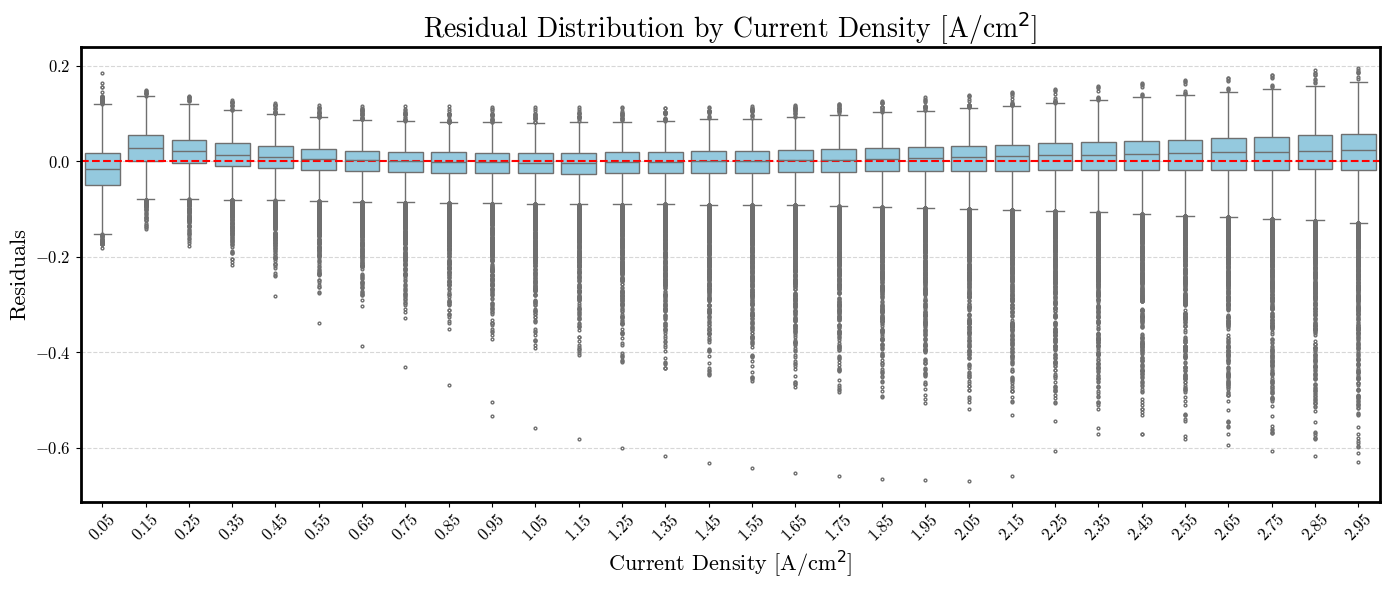

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Bin the 'ifc' values to create groups (like current_density_index)
test_df = test_df.copy()
test_df['ifc_bin'] = pd.cut(test_df['ifc'], bins=30, labels=False) + 1  # 1-indexed bins
test_df['residual'] = residuals

# Calculate bin centers for x-axis labels
bin_edges = pd.cut(test_df['ifc'], bins=30).unique().categories
bin_centers = [(interval.left + interval.right) / 2 for interval in bin_edges]
bin_labels = [f"{center:.2f}" for center in bin_centers]

plt.figure(figsize=(14, 6))
sns.boxplot(
    data=test_df,
    x='ifc_bin',
    y='residual',
    color='skyblue',
    fliersize=2,
    linewidth=1
)

plt.axhline(0, color="red", linestyle="--")

# Larger font sizes for ticks and labels
plt.xticks(ticks=range(len(bin_labels)), labels=bin_labels, fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.title("Residual Distribution by Current Density [A/cm$^2$]", fontsize=20)
plt.xlabel("Current Density [A/cm$^2$]", fontsize=16)
plt.ylabel("Residuals", fontsize=16)

plt.grid(True, linestyle='--', axis='y', alpha=0.5)
plt.tight_layout()
plt.show()


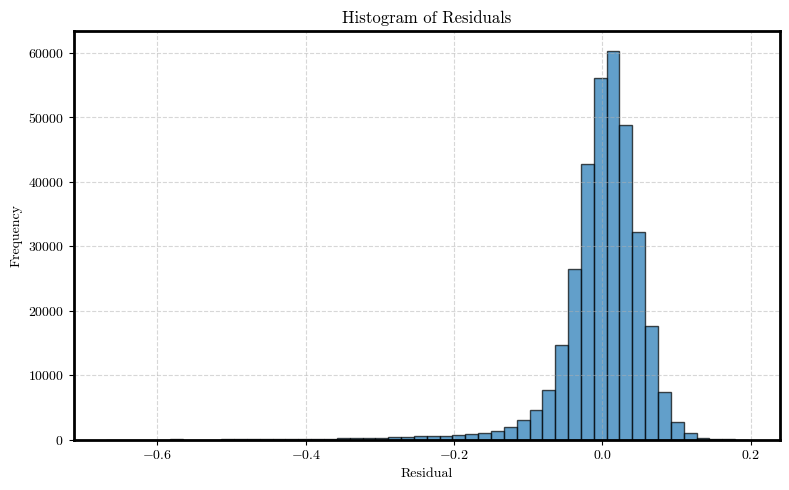

In [238]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [239]:
import shap
explainer = shap.KernelExplainer(model.predict, test_df[parameters].sample(100, random_state=1))
shap_values = explainer.shap_values(test_df[parameters].sample(1000, random_state=1), nsamples=100)



100%|██████████| 1000/1000 [11:41<00:00,  1.42it/s]


C:\Users\dejvi\AppData\Local\Temp\ipykernel_1116\1711972388.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, sample_df, show=False)


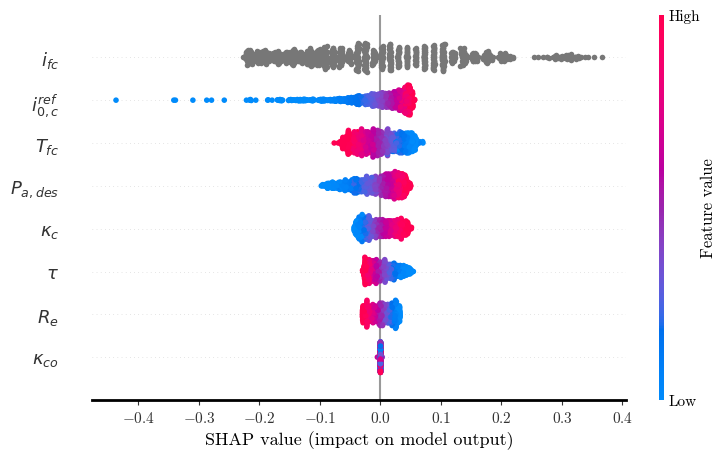

In [240]:
import matplotlib.pyplot as plt
import shap

# Your original feature name to LaTeX mapping
latex_map = {
    'ifc': r'$i_{fc}$',
    'i0_c_ref': r'$i_{0,c}^{ref}$',
    'kappa_c': r'$\kappa_c$',
    'Pa_des': r'$P_{a,des}$',
    'Tfc': r'$T_{fc}$',
    'tau': r'$\tau$',
    'Re': r'$R_e$',
    'kappa_co': r'$\kappa_{co}$'
}


# 1. Use original DataFrame with original column names (or renamed if you prefer)
sample_df = test_df[parameters].sample(1000, random_state=1)

# 2. Plot with original column names but capture the current axis and do not show yet
shap.summary_plot(shap_values, sample_df, show=False)

# 3. Get the y-tick labels currently set by SHAP (these are the feature names in order of importance)
ax = plt.gca()
current_labels = [label.get_text() for label in ax.get_yticklabels()]

# 4. Map current labels to LaTeX using your dictionary
latex_labels = [latex_map.get(label, label) for label in current_labels]

# 5. Set new y-tick labels with LaTeX
ax.set_yticklabels(latex_labels)

plt.show()


C:\Users\dejvi\AppData\Local\Temp\ipykernel_1116\3074830066.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, sample_df, plot_type="bar", show=False)


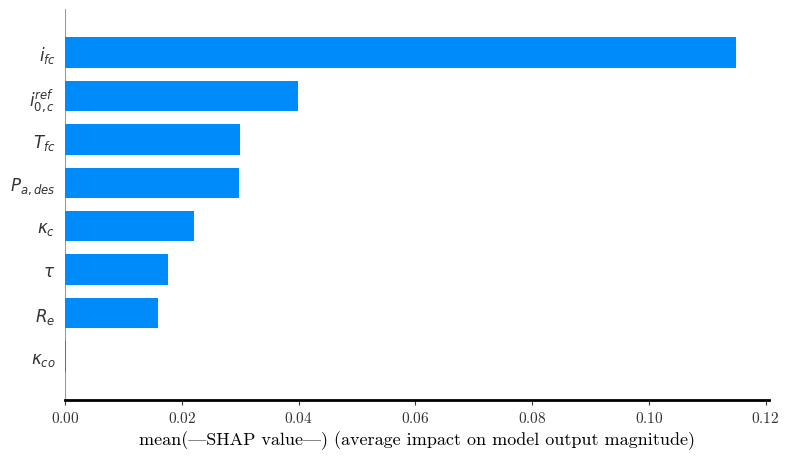

In [241]:
# Create the bar plot but do not show yet
shap.summary_plot(shap_values, sample_df, plot_type="bar", show=False)

ax = plt.gca()
current_labels = [label.get_text() for label in ax.get_yticklabels()]

# Map to LaTeX, default to original if not found
latex_labels = [latex_map.get(label, label) for label in current_labels]

# Set new y-axis tick labels with LaTeX formatting
ax.set_yticklabels(latex_labels, fontsize=12)

plt.tight_layout()
plt.show()